# Assignment 3: Solving Traveling Salesman Problem using Simulated Annealing

The basic Traveling Salesman Problem (TSP) is assumed to be known. Here we ask you to try and solve the problem under the following simplifying assumptions:

- There are paths from all cities to all other cities.
- The triangle inequality holds for these paths, i.e., a detour via another city will always result in a path that is at least as long as the direct path between two cities.
- The problem is symmetric, i.e., the path from A to B has the same length as that from B to A.

You may also assume that all cities lie in a plane. The quantity to be optimized is the total length of a circuit; the recommended elementary edit is 2-opt, where two non-adjacent edges are deleted and the four cities are reconnected so that a new circuit is created. Moving a single city (node) to another location in the circuit can also be effective. Swapping two nodes is not a good idea, in general.

There are three cities configuration files provided in TSP-Configurations.zip. Test your implementation on the smallest problem, `eli51.tsp`, then try to address bigger problems, `a280.tsp` and `pbc442.tsp`.
Focus your analysis and experiments on `a280.tsp`. 
Few experiments that you could perform are:

- First of all, you at least need to be able to converge to a good local minimum although the goal is to find the global optima or the shortest path.
- Second, try different cooling schedules and observe their effects on convergence.
- Third, what’s the effects of Markov Chain’s length on the convergence.

## Basic imports and functions(class Temperature,calculate_total_distance,simulated_annealing)

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

class Temperature:
    def __init__(self, f, parameters):
        """
        Initialize temperature class

        Parameters
        ----------
        f : function
            Function to update temperature
        parameters : dict
            Dictionary of parameters
            Should contain:
                initial_temp : float
                    Initial temperature
                max_iter : int
                    Maximum number of iterations
                markov_chain_length : int
                    Length of markov chain
        """

        # Check if parameters contains all necessary keys
        assert "initial_temp" in parameters, "parameters must contain 'initial_temp'"
        assert "max_iter" in parameters, "parameters must contain 'max_iter'"
        assert "markov_chain_length" in parameters, "parameters must contain 'markov_chain_length'"

        self.updatefunction = f
        self.parameters = parameters
        self.current_temp = parameters["initial_temp"]
        self.iter = 1  #Initialize iteration counter

    def update_temperature(self):
        """Method to update temperature"""
        self.current_temp = self.updatefunction(self.current_temp, self.iter, self.parameters)
        self.iter += 1


def calculate_total_distance(cities, route):
    """Calculate the total distance for a given route"""
    total_distance = 0
    number_of_cities = len(cities)

    for i in range(number_of_cities):
        # Calculate the distance between adjacent cities
        city1 = cities[route[i % number_of_cities]]
        city2 = cities[route[(i + 1) % number_of_cities]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance
        
    return total_distance

def simulated_annealing(cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function"""

    # Randomly initialize a solution (route)
    current_route = list(range(len(cities)))
    random.shuffle(current_route)

    current_distance = calculate_total_distance(cities, current_route)
    temper = Temperature(Cooling_fuction, parameters)
    
    intermediate_routes = []
    intermediate_distances = []
    intermediate_temps = []
    
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
                current_route = new_route
                current_distance = new_distance
        
        intermediate_routes.append(current_route)
        intermediate_distances.append(current_distance)
        intermediate_temps.append(temper.current_temp)

        temper.iter += 1
        temper.update_temperature()

    intermediate_results = dict({
        "intermediate_routes": intermediate_routes,
        "intermediate_distances": intermediate_distances,
        "intermediate_temps": intermediate_temps
    })

    print(temper.iter)
    print(temper.current_temp)
    return current_route, current_distance, intermediate_results

## Cooling functions

In [3]:
def Geometric_cooling(current_temp, iter, parameters):
    assert "cooling_rate" in parameters, "parameters must contain 'cooling_rate' for Geometric cooling"
    return current_temp * parameters["cooling_rate"]

def Basic_cooling(current_temp, iter, parameters):
    assert "a" in parameters, "parameters must contain 'a' for Basic cooling"
    assert "b" in parameters, "parameters must contain 'b' for Basic cooling"
    return parameters["a"] / np.log(iter + parameters["b"])

## Optimizing route functions

In [4]:
def two_opt_swap(route):
    """
    Applies 2-opt swapping on the given route between cities i and k
    
    Parameters
    ----------
    route : list
        List of cities (integers)
    
    Returns
    -------
    route : list
        List of cities (integers) with two cities swapped    
    """
    i, k = sorted(random.sample(range(1, len(route)), 2))
    new_route = route[0:i]
    new_route.extend(reversed(route[i:k + 1]))
    new_route.extend(route[k + 1:])
    return new_route

def move_node(route):
    """
    Move a city to a new position in the route.

    Parameters
    ----------
    route : list
        List of cities (integers)
    
    Returns
    -------
    route : list
        List of cities (integers) with one city moved
    """
    i, k = random.sample(range(1, len(route)), 2)
    city = route.pop(i)  # Remove the city from its current position
    route.insert(k, city)  # Insert the city at the new position
    return route


## read_tsp_file

In [5]:
# First, read the uploaded file eil51.tsp.txt
file_path = 'plots/eil51.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
cities = read_tsp_file(file_path)

In [6]:
initial_temp = 1000
cooling_rate = 0.99
max_iter = 10000
parameters_Geometric_cooling = {"initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":10, 
                                "cooling_rate": cooling_rate}

parameters_Basic_cooling = {"initial_temp" : initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":10, 
                            "a" : 10, 
                            "b" : 5}

cooling_functions = [
    (Geometric_cooling, parameters_Geometric_cooling),
    (Basic_cooling, parameters_Basic_cooling)
]

optimal_routes = []
optimal_distances = []
for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, intermediate_results = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

10001
1.499591560997956e-19
Optimal Route: [24, 13, 23, 42, 6, 22, 47, 5, 26, 50, 45, 11, 46, 17, 3, 16, 36, 4, 48, 37, 10, 15, 1, 21, 31, 0, 7, 25, 30, 27, 2, 35, 34, 19, 28, 20, 33, 49, 8, 29, 9, 38, 32, 44, 14, 43, 41, 18, 39, 40, 12]
Optimal Distance: 441.34321958333317

10001
1.085677281531147
Optimal Route: [5, 47, 22, 23, 42, 6, 7, 25, 30, 27, 21, 2, 35, 34, 19, 1, 28, 20, 15, 49, 33, 29, 38, 9, 32, 44, 14, 36, 4, 48, 8, 37, 10, 31, 0, 26, 45, 50, 11, 46, 17, 3, 16, 43, 41, 39, 18, 40, 12, 24, 13]
Optimal Distance: 448.8523668103602



## Visualization part

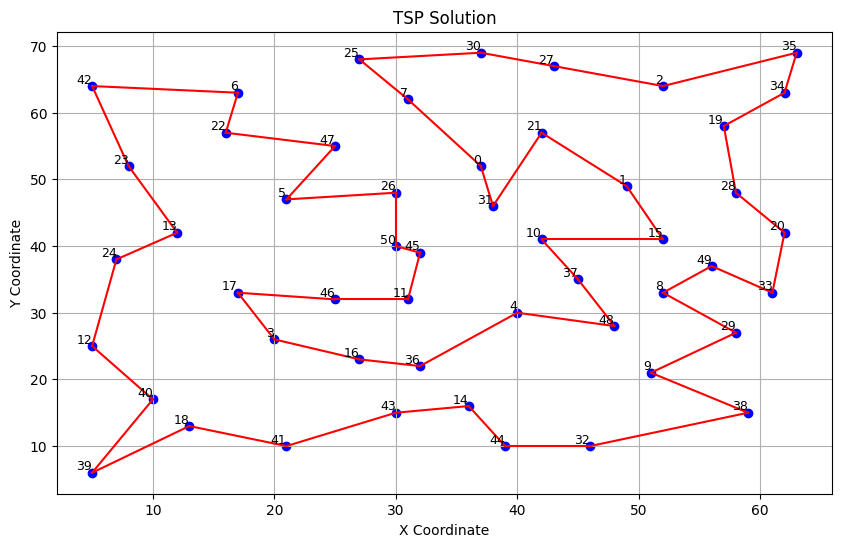

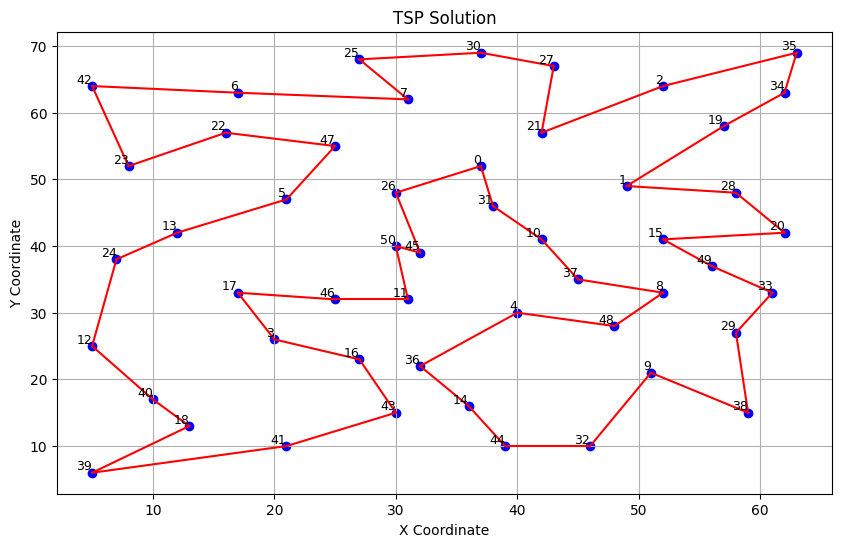

In [7]:
def plot_tsp_solution(cities, route):
    """Drawing a solution to the traveling salesman problem"""
    plt.figure(figsize=(10, 6))

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    for i in range(len(route)):
        start_city = cities[route[i]]
        end_city = cities[route[(i + 1) % len(route)]]
        plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color='red')

    plt.title('TSP Solution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()
# Draw the solution using the optimal path and city coordinates found previously
for optimal_route in optimal_routes:
    plot_tsp_solution(cities, optimal_route)

In [28]:
from matplotlib.animation import FuncAnimation

def animate_solution(cities, intermediate_routes):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Filter down intermediate_routes to only keep route if its different from the previous one
    intermediate_routes = [route for i, route in enumerate(intermediate_routes) if i == 0 or route != intermediate_routes[i - 1]]

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    line, = plt.plot([], [], color='red')

    def animate(i):
        route = intermediate_routes[i]
        x = [cities[route[i % len(route)]][0] for i in range(len(route) + 1)]
        y = [cities[route[i % len(route)]][1] for i in range(len(route) + 1)]
        line.set_data(x, y)
        return line,

    # Skip frames if too many routes
    anim = FuncAnimation(fig, animate, frames=len(intermediate_routes), interval=1000/30, blit=True)
    anim.save('animation.gif', writer='imagemagick', fps=30)
    plt.close()
    return anim

In [29]:
animate_solution(cities, intermediate_results["intermediate_routes"])

MovieWriter imagemagick unavailable; using Pillow instead.
